# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

<h1><font="red">Import some usefull library</h1>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:
conn=sqlite3.connect('database.sqlite')
# Only take positive & Negative reviews with score!=3 

data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score!=3 LIMIT 6000""",conn)

# Give score>3, Positive and Score<3 Negative
def partition(x):
    if x<3:
      return 0
    else:
        return 1

# Change Reviews with score <3 or >3 to 0 and 1 respectively in orignal data

actualscore=data["Score"]
PositiveNegative=actualscore.map(partition)
data["Score"]=PositiveNegative
print("Number of data points in our data",data.shape)
data.head(3)

Number of data points in our data (6000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
# Select only those data in which Count(*)>1 ie, Users who purchased item more than once
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", conn)

print("Number Of data points left after ",display.shape)
display.head(3)


Number Of data points left after  (80668, 9)


,UserId,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,2,3,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",0,0,1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,0,2,1348531200,1,This coffee is horrible and unfortunately not ...,2


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", conn)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

# Sorting of data according to time & Deduplication of data

In [5]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03
mean,3256.262500,1.566000,1.997000,0.838000,1.294451e+09
std,1877.291293,4.925142,5.473145,0.368482,4.861240e+07
min,1.000000,0.000000,0.000000,0.000000,9.617184e+08
25%,1625.750000,0.000000,0.000000,1.000000,1.269734e+09
50%,3266.500000,0.000000,1.000000,1.000000,1.309306e+09
75%,4886.250000,2.000000,2.000000,1.000000,1.330387e+09
max,6495.000000,165.000000,168.000000,1.000000,1.351210e+09


In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries 
final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_data.shape

(5979, 10)

In [7]:
# Check how much % of data left after remove deduplicated data points
(final_data["Id"].size*1.0)/(data["Id"].size*1.0)*100

99.65

<h2>Value of HelpfulnessNumerator must be smaller than equal to HelpfulnessDenominator 

In [8]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final_data.shape)

#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()

(5979, 10)


1    5014
0     965
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# printing some random reviews
sent_0 = final_data['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
The negative reviews of Mrs Mays products just because it is made in China are not really valid, cannot base on other companies' poor quality control and apply to every company in the country!  There are many bad quality foods that are made in the USA that's bad for your health, so just because it's labeled made in USA doesn't mean it is good quality.  As long as a company takes pride in their quality control and not greed for profit only deserves good ratings and fair sales.
Well, I opened it and it is grayish sticky mess. I'm so mad at myself for wasting my money, and not trying to make it from scratch at home. Which would probably end up better and cheaper. Oh well, live and learn!
These crackers are a great healthy snack without anything spread on them. My only dislike is that they are a tad too sweet for me. I'd li

In [11]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [12]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
The negative reviews of Mrs Mays products just because it is made in China are not really valid, cannot base on other companies' poor quality control and apply to every company in the country!  There are many bad quality foods that are made in the USA that's bad for your health, so just because it's labeled made in USA doesn't mean it is good quality.  As long as a company takes pride in their quality control and not greed for profit only deserves good ratings and fair sales.
Well, I opened it and it is grayish sticky mess. I'm so mad at myself for wasting my money, and not trying to make it from scratch at home. Which would probably end up better and cheaper. Oh well, live and learn!
These crackers are a great healthy snack without anything spread on them. My only dislike is that they are a tad too sweet for me. I'd li

In [13]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Well, I opened it and it is grayish sticky mess. I am so mad at myself for wasting my money, and not trying to make it from scratch at home. Which would probably end up better and cheaper. Oh well, live and learn!


In [15]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Well I opened it and it is grayish sticky mess I am so mad at myself for wasting my money and not trying to make it from scratch at home Which would probably end up better and cheaper Oh well live and learn 


In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_data['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 5979/5979 [00:02<00:00, 2386.55it/s]


In [19]:
preprocessed_reviews[1500]

'well opened grayish sticky mess mad wasting money not trying make scratch home would probably end better cheaper oh well live learn'

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [20]:
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final_data['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 5979/5979 [00:01<00:00, 4668.88it/s]


# [4] Featurization

## [4.1] BAG OF WORDS [Text]

In [21]:
#BoW
count_vect = CountVectorizer(max_features=10000) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absolutly', 'absorb', 'absorbed']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5979, 10000)
the number of unique words  10000


## [4.2] Bi-Grams and n-Grams [Text]

In [22]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams

count_vect = CountVectorizer(ngram_range=(1,3), min_df=5, max_features=10000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams,bigrams & Trigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5979, 8309)
the number of unique words including both unigrams,bigrams & Trigrams  8309


## [4.3] Tf-Idf [Text]

In [23]:
tfidf_vect=TfidfVectorizer(ngram_range=(1,3), min_df=5, max_features=10000)
final_bigram_tfidf = tfidf_vect.fit_transform(preprocessed_reviews)
print("the type of tfidf vectorizer ",type(final_bigram_tfidf))
print("the shape of out text tfidf vectorizer ",final_bigram_tfidf.get_shape())
print("the number of unique words including both unigrams,bigrams & Trigrams ", final_bigram_tfidf.get_shape()[1])

the type of tfidf vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text tfidf vectorizer  (5979, 8309)
the number of unique words including both unigrams,bigrams & Trigrams  8309


# [4.4] Avg W2V

In [24]:
# Train your own Word2Vec model using your own text corpus

list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [25]:

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=6)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

D:\Anaconda\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


[('calorie', 0.9857889413833618), ('alternative', 0.9857410192489624), ('original', 0.9836202263832092), ('greasy', 0.9828788042068481), ('satisfying', 0.9827536344528198), ('ahoy', 0.981505811214447), ('salted', 0.9814978837966919), ('fried', 0.9813567399978638), ('potatoe', 0.9811697006225586), ('addictive', 0.9810700416564941)]
[('hands', 0.9986903667449951), ('opinion', 0.9982612729072571), ('eggnog', 0.998073160648346), ('doubt', 0.9979889392852783), ('thus', 0.9978457689285278), ('united', 0.9976251125335693), ('generally', 0.9976143836975098), ('berry', 0.9975715279579163), ('typically', 0.997468113899231), ('simply', 0.9974265694618225)]


In [26]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4278
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'mae', 'ploy', 'sweet', 'chili', 'sauce', 'becoming', 'standard', 'condiment', 'dinner']


In [27]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5979/5979 [00:04<00:00, 1473.32it/s]


5979
50


# [4.5] TFIDF weighted W2v

In [28]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [29]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5979/5979 [00:25<00:00, 230.12it/s]


<h1>[4.6] Plot TSNE plot for visualization of data 

<h1>[4.6.1] For BOW without n_grams of Text

   Dimension_x1  Dimension_y1  Score
0    -18.253429     17.522884    1.0
1    -97.602051      7.349698    1.0
2    -13.499241     90.414536    1.0
3     -9.394265     10.947368    1.0
4     18.464937   -112.434029    1.0
BOW Without n_grams, with perplexity = 2


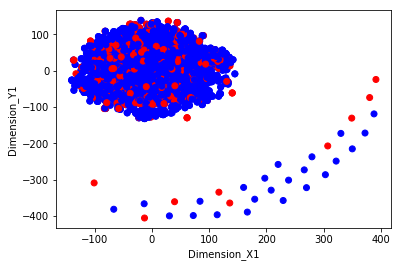

   Dimension_x1  Dimension_y1  Score
0    -15.990446     -5.353951    1.0
1      2.215929    -67.927345    1.0
2    -54.021095    -37.267624    1.0
3    -18.182426      0.111223    1.0
4    -83.440018     24.187490    1.0
BOW Without n_grams, with perplexity = 5


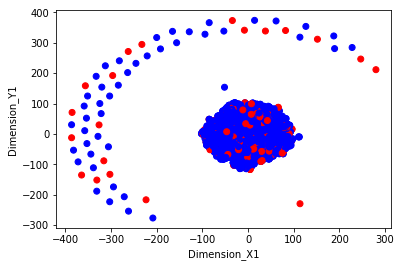

   Dimension_x1  Dimension_y1  Score
0     15.666969    -11.268306    1.0
1     21.347595     20.410427    1.0
2     44.296467    -14.626897    1.0
3     27.757071    -17.719091    1.0
4     53.890423     26.710011    1.0
BOW Without n_grams, with perplexity = 10


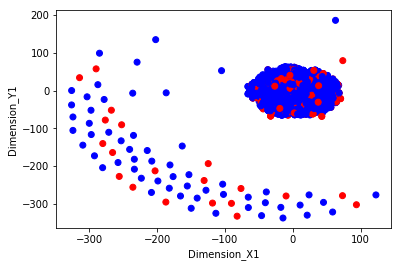

   Dimension_x1  Dimension_y1  Score
0      6.460380      7.069372    1.0
1      5.934345      8.361277    1.0
2     13.222033      7.934249    1.0
3      8.040746      4.089909    1.0
4     16.142248      2.376000    1.0
BOW Without n_grams, with perplexity = 30


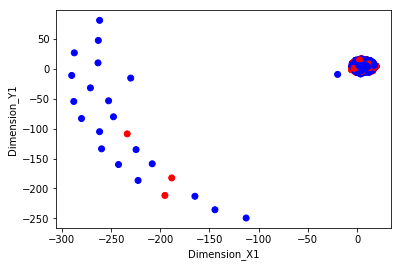

   Dimension_x1  Dimension_y1  Score
0     -3.478284     -0.678925    1.0
1     -3.467741     -1.682330    1.0
2     -8.064052      0.179092    1.0
3     -3.454040      1.229944    1.0
4     -6.415642     -4.302573    1.0
BOW Without n_grams, with perplexity = 50


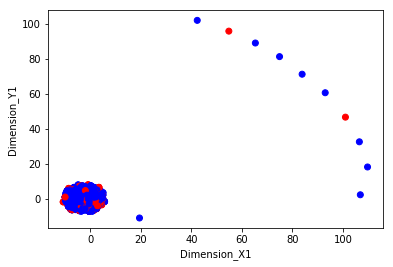

   Dimension_x1  Dimension_y1  Score
0      0.911871     -1.952497    1.0
1      0.078269     -1.833680    1.0
2     -1.392299     -2.849138    1.0
3      1.905371     -2.921635    1.0
4     -1.376703      1.081599    1.0
BOW Without n_grams, with perplexity = 100


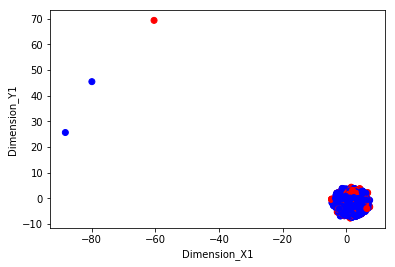

In [30]:
from sklearn.manifold import TSNE

x1=final_counts
y1=final_data["Score"]

perplexity=[2,5,10,30,50,100]
for p in perplexity:
    
    tsne1 = TSNE(n_components=2, perplexity=p,n_iter=5000, learning_rate=700)

    X_embedding1 = tsne1.fit_transform(x1.toarray())            # TSNE accept Dense matrix

    plot_tsne1 = np.hstack((X_embedding1, y1.values.reshape(-1,1)))
    plot_tsne_df1 = pd.DataFrame(data=plot_tsne1, columns=['Dimension_x1','Dimension_y1','Score'])
    print(plot_tsne_df1.head())
    colors = {0:'red', 1:'blue'}
    plt.scatter(plot_tsne_df1['Dimension_x1'], plot_tsne_df1['Dimension_y1'], c=plot_tsne_df1['Score'].apply(lambda x: colors[x]))
    print("BOW Without n_grams, with perplexity =",p)
    plt.xlabel("Dimension_X1")
    plt.ylabel("Dimension_Y1")

    plt.show()

<h1>[4.6.2] For BOW with n_grams Text

   Dimension_x2  Dimension_y2  Score
0    -44.062508     45.073029    1.0
1     -3.475837     81.346527    1.0
2    -64.841545     69.040100    1.0
3    -25.361988     20.459476    1.0
4    -34.427021    -81.999573    1.0
BOW With n_grams, with perplexity = 2


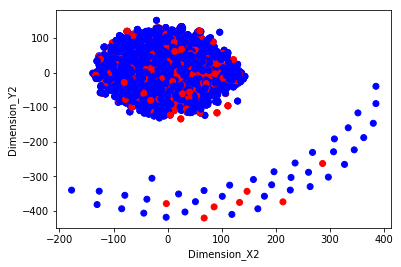

   Dimension_x2  Dimension_y2  Score
0      5.860119    -17.385267    1.0
1    -32.715855    -20.975569    1.0
2     63.643291    -17.588152    1.0
3      9.965912     -7.842085    1.0
4    -52.427658    -45.714546    1.0
BOW With n_grams, with perplexity = 5


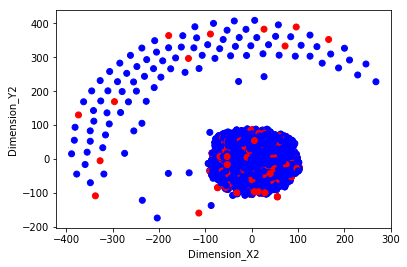

   Dimension_x2  Dimension_y2  Score
0     15.252880      8.407177    1.0
1    -11.602836    -10.354465    1.0
2     23.718372     42.010574    1.0
3     -6.598168     11.034744    1.0
4    -12.497215    -35.825531    1.0
BOW With n_grams, with perplexity = 10


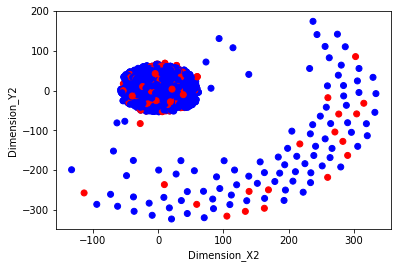

   Dimension_x2  Dimension_y2  Score
0     -0.507605      3.658216    1.0
1     -5.204630      2.749731    1.0
2     -7.570628     10.578968    1.0
3     -2.861982      5.048371    1.0
4    -10.117115     -0.105505    1.0
BOW With n_grams, with perplexity = 30


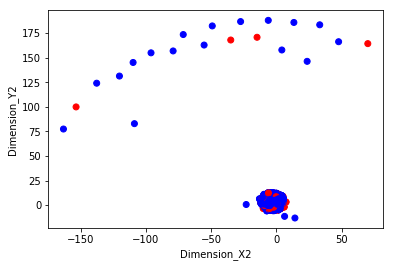

   Dimension_x2  Dimension_y2  Score
0     -1.683493     -1.908703    1.0
1     -4.214882     -0.826071    1.0
2     -6.621698     -4.511204    1.0
3     -2.916237     -2.597343    1.0
4     -8.019855      0.436983    1.0
BOW With n_grams, with perplexity = 50


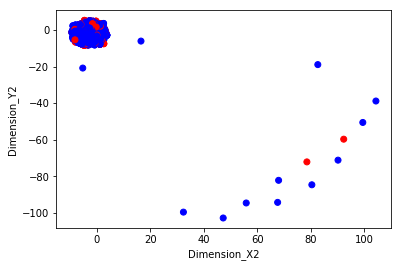

   Dimension_x2  Dimension_y2  Score
0      2.612123     -1.097946    1.0
1      3.167408      1.331157    1.0
2      6.561002     -0.688693    1.0
3      3.342792     -0.528592    1.0
4      5.253326      2.708220    1.0
BOW With n_grams, with perplexity = 100


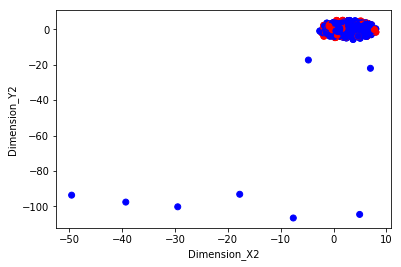

In [31]:
from sklearn.manifold import TSNE


x2=final_bigram_counts
y2=final_data["Score"]

perplexity=[2,5,10,30,50,100]
for p in perplexity:
    
    tsne2 = TSNE(n_components=2, perplexity=p,n_iter=5000, learning_rate=700)

    X_embedding2 = tsne2.fit_transform(x2.toarray())            # TSNE accept Dense matrix

    plot_tsne2 = np.hstack((X_embedding2, y2.values.reshape(-1,1)))
    plot_tsne_df2 = pd.DataFrame(data=plot_tsne2, columns=['Dimension_x2','Dimension_y2','Score'])
    print(plot_tsne_df2.head())
    colors = {0:'red', 1:'blue'}
    plt.scatter(plot_tsne_df2['Dimension_x2'], plot_tsne_df2['Dimension_y2'], c=plot_tsne_df2['Score'].apply(lambda x: colors[x]))
    print("BOW With n_grams, with perplexity =",p)
    plt.xlabel("Dimension_X2")
    plt.ylabel("Dimension_Y2")

    plt.show()

<h1>[4.6.3] For Tf-Idf ,Text

   Dimension_x3  Dimension_y3  Score
0     -2.377656     -0.353975    1.0
1     -3.084435     -0.592483    1.0
2    -23.013525     10.078322    1.0
3     -4.018018     -0.555146    1.0
4     -2.272122     -0.461030    1.0
TF-IDF, with perplexity = 2


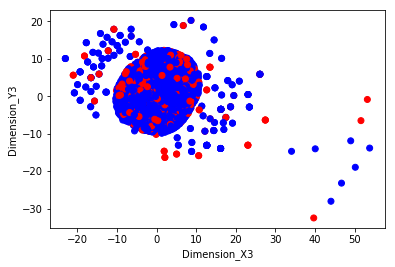

   Dimension_x3  Dimension_y3  Score
0      3.692355     -2.050633    1.0
1      3.296642     -0.839033    1.0
2     -1.281645     10.282781    1.0
3      0.749967     -5.128086    1.0
4      2.747308      0.046250    1.0
TF-IDF, with perplexity = 5


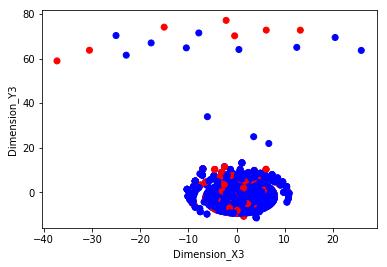

   Dimension_x3  Dimension_y3  Score
0     -0.909432      0.895930    1.0
1     -3.836799     -6.405914    1.0
2      0.838843      9.344964    1.0
3     -1.893212      1.668507    1.0
4     -2.031424     -2.042324    1.0
TF-IDF, with perplexity = 10


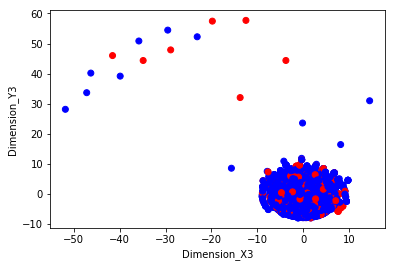

   Dimension_x3  Dimension_y3  Score
0      0.230434      1.926438    1.0
1     -0.570351      1.297614    1.0
2     -2.146386     -0.917767    1.0
3     -0.724681     -1.026605    1.0
4     -2.085797     -3.777081    1.0
TF-IDF, with perplexity = 30


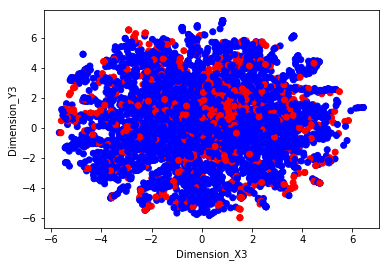

   Dimension_x3  Dimension_y3  Score
0     -0.875701      0.185978    1.0
1      3.083230      0.786073    1.0
2     -2.232471      1.288612    1.0
3     -1.380506     -0.327857    1.0
4      4.359220     -0.184023    1.0
TF-IDF, with perplexity = 50


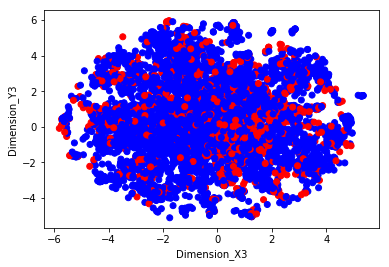

   Dimension_x3  Dimension_y3  Score
0      3.282977      0.976275    1.0
1      5.527122      1.988078    1.0
2      4.476095      2.539606    1.0
3      1.213968      2.461688    1.0
4      4.789904      4.106911    1.0
TF-IDF, with perplexity = 100


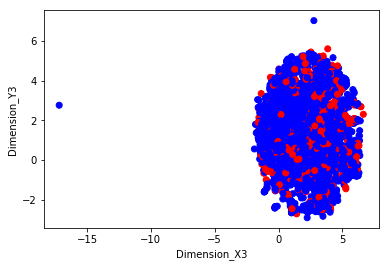

In [35]:
from sklearn.manifold import TSNE


x3=final_bigram_tfidf
y3=final_data["Score"]

perplexity=[2,5,10,30,50,100]
for p in perplexity:
    tsne3 = TSNE(n_components=2, perplexity=p,n_iter=5000, learning_rate=700)

    X_embedding3 = tsne3.fit_transform(x3.toarray())            # TSNE accept Dense matrix

    plot_tsne3 = np.hstack((X_embedding3, y3.values.reshape(-1,1)))
    plot_tsne_tfidf3 = pd.DataFrame(data=plot_tsne3, columns=['Dimension_x3','Dimension_y3','Score'])
    print(plot_tsne_tfidf3.head())
    colors = {0:'red', 1:'blue'}
    plt.scatter(plot_tsne_tfidf3['Dimension_x3'], plot_tsne_tfidf3['Dimension_y3'], c=plot_tsne_tfidf3['Score'].apply(lambda x: colors[x]))
    print("TF-IDF, with perplexity =",p)
    plt.xlabel("Dimension_X3")
    plt.ylabel("Dimension_Y3")
    plt.show()

<h1>[4.6.4] For Avg_W2V ,Text

   Dimension_x4  Dimension_y4  Score
0   -213.940689    118.219421    1.0
1   -150.749069      8.634547    1.0
2   -239.918762     12.913192    1.0
3   -195.755264   -120.048141    1.0
4    159.156540   -132.642273    1.0
AVG_W2V, with perplexity = 2


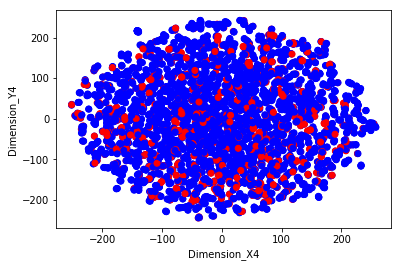

   Dimension_x4  Dimension_y4  Score
0   -148.056580    -83.606430    1.0
1   -143.496216    -83.835663    1.0
2   -102.762474     39.009979    1.0
3    -79.374786     29.976643    1.0
4   -144.452271      1.487861    1.0
AVG_W2V, with perplexity = 5


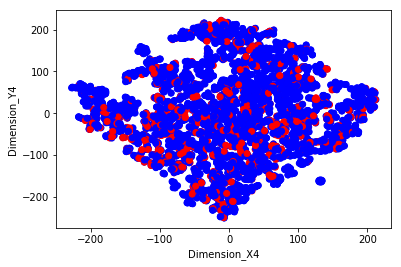

   Dimension_x4  Dimension_y4  Score
0     70.765442   -116.560837    1.0
1     57.818222   -120.876305    1.0
2    108.607307    -58.396370    1.0
3     98.144592    -50.413074    1.0
4    -40.423428   -127.111763    1.0
AVG_W2V, with perplexity = 10


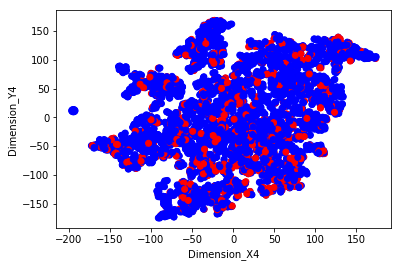

   Dimension_x4  Dimension_y4  Score
0     39.939457    -73.481628    1.0
1     42.046646    -66.898949    1.0
2    -15.846577    -72.527542    1.0
3    -15.281589    -63.445194    1.0
4     97.906166    -10.205940    1.0
AVG_W2V, with perplexity = 30


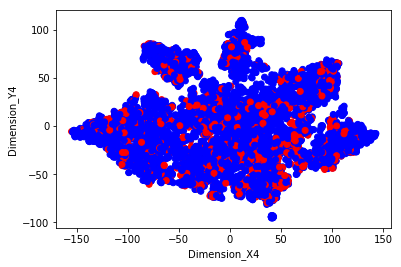

   Dimension_x4  Dimension_y4  Score
0     51.034794     26.384098    1.0
1     46.240425     28.345783    1.0
2     50.660069     -3.061962    1.0
3     44.026623     -5.569848    1.0
4     10.375157     78.784195    1.0
AVG_W2V, with perplexity = 50


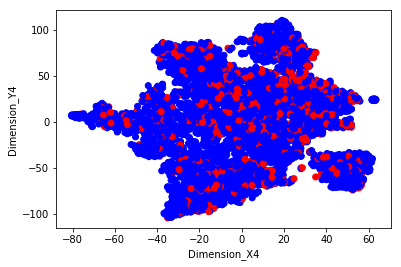

   Dimension_x4  Dimension_y4  Score
0    -16.388371     23.631742    1.0
1    -17.681030     20.916473    1.0
2     11.693409      5.241789    1.0
3     10.426840      3.798094    1.0
4    -30.285425    -19.976089    1.0
AVG_W2V, with perplexity = 100


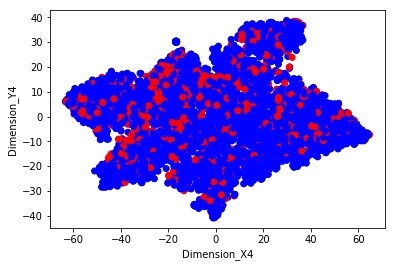

In [30]:
from sklearn.manifold import TSNE


x4=sent_vectors
y4=final_data["Score"]

perplexity=[2,5,10,30,50,100]
for p in perplexity:
    tsne4 = TSNE(n_components=2,perplexity=p,n_iter=5000, learning_rate=700)

    X_embedding4 = tsne4.fit_transform(x4)          
    plot_tsne4 = np.hstack((X_embedding4, y4.values.reshape(-1,1)))
    plot_tsne_w2v4 = pd.DataFrame(data=plot_tsne4, columns=['Dimension_x4','Dimension_y4','Score'])
    print(plot_tsne_w2v4.head())
    colors = {0:'red', 1:'blue'}
    plt.scatter(plot_tsne_w2v4['Dimension_x4'], plot_tsne_w2v4['Dimension_y4'], c=plot_tsne_w2v4['Score'].apply(lambda x: colors[x]))
    print("AVG_W2V, with perplexity =",p)
    plt.xlabel("Dimension_X4")
    plt.ylabel("Dimension_Y4")

    plt.show()

<h1>[4.6.5] For tfidf_W2V ,Text

   Dimension_x5  Dimension_y5  Score
0    -40.122738    229.162689    1.0
1     20.123581    221.789551    1.0
2    -46.293705    207.672348    1.0
3    -94.871384    -86.763000    1.0
4    148.575180   -129.278015    1.0
TF-IDF_W2V, with perplexity = 2


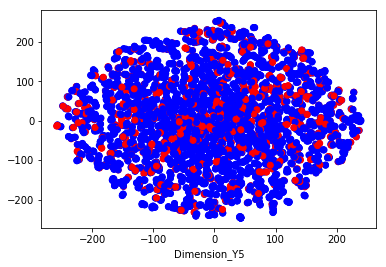

   Dimension_x5  Dimension_y5  Score
0     21.414461    203.714386    1.0
1     50.188396    178.843063    1.0
2     11.917975    196.713196    1.0
3    -23.302528   -150.239517    1.0
4    196.590912    -80.213966    1.0
TF-IDF_W2V, with perplexity = 5


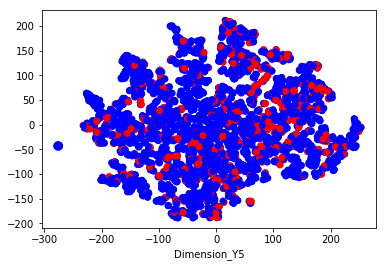

   Dimension_x5  Dimension_y5  Score
0   -159.185226     -8.272187    1.0
1   -142.866791     14.222050    1.0
2   -156.336243    -16.404646    1.0
3    -67.766891    -38.099270    1.0
4    -45.344063    143.202194    1.0
TF-IDF_W2V, with perplexity = 10


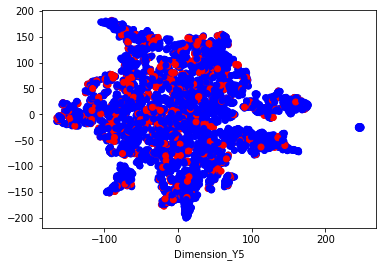

   Dimension_x5  Dimension_y5  Score
0   -101.387993      6.071871    1.0
1    -91.414680     16.219797    1.0
2   -103.030350     -0.706760    1.0
3    -54.871136    -20.898705    1.0
4    -17.471090    103.738678    1.0
TF-IDF_W2V, with perplexity = 30


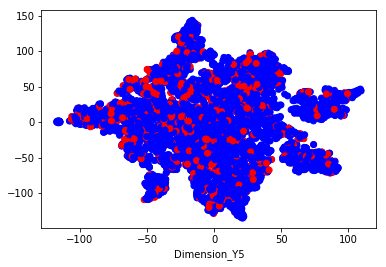

   Dimension_x5  Dimension_y5  Score
0     64.985672    -28.566916    1.0
1     57.070374    -32.113098    1.0
2     68.437965    -23.819332    1.0
3     40.715073     -0.587848    1.0
4     -8.084088    -77.671951    1.0
TF-IDF_W2V, with perplexity = 50


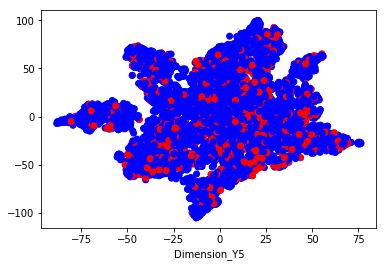

   Dimension_x5  Dimension_y5  Score
0    -36.276962     13.159916    1.0
1    -31.712053     15.298904    1.0
2    -38.036221      9.846573    1.0
3    -19.387609     -1.841721    1.0
4     -6.431304     47.983459    1.0
TF-IDF_W2V, with perplexity = 100


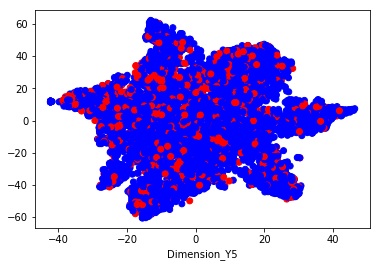

In [31]:
from sklearn.manifold import TSNE


x5=tfidf_sent_vectors
y5=final_data["Score"]

perplexity=[2,5,10,30,50,100]
for p in perplexity:

    tsne5 = TSNE(n_components=2, perplexity=p,n_iter=5000, learning_rate=700)

    X_embedding5 = tsne5.fit_transform(x5)            # TSNE accept Dense matrix

    plot_tsne5 = np.hstack((X_embedding5, y5.values.reshape(-1,1)))
    plot_tsne_tfidf_w2v5 = pd.DataFrame(data=plot_tsne5, columns=['Dimension_x5','Dimension_y5','Score'])
    print(plot_tsne_tfidf_w2v5.head())
    colors = {0:'red', 1:'blue'}
    plt.scatter(plot_tsne_tfidf_w2v5['Dimension_x5'], plot_tsne_tfidf_w2v5['Dimension_y5'], c=plot_tsne_tfidf_w2v5['Score'].apply(lambda x: colors[x]))
    print("TF-IDF_W2V, with perplexity =",p)
    plt.xlabel("Dimension_X5")
    plt.xlabel("Dimension_Y5")

    plt.show()

<h1><font color="red" size=30>CONCLUSION</h1>

<p>Always check for multiple value of perplexity as shown in above, I use perplexities = [2,5,10,30,50,100].<br>
In above Program I use TSNE Algorithm for dimensional reduction on AMAZON FINE FOOD REVIEWS dataset. 
    First, Convert text reviews into vectors using BOW, TF-IDF, Avg-W2V, TFIDF-W2V.</p>

It is seen for perplexity = 30 or 50 data is fairly spread without any much outliers. Also it is good to use TFIDF-W2V and W2V than others.

<h3><b>[NOTE : The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.]</h3></b>